First we want to isolate the cementum region. We can (hopefully) do this by performing fits to the mean intensity along the y-axis

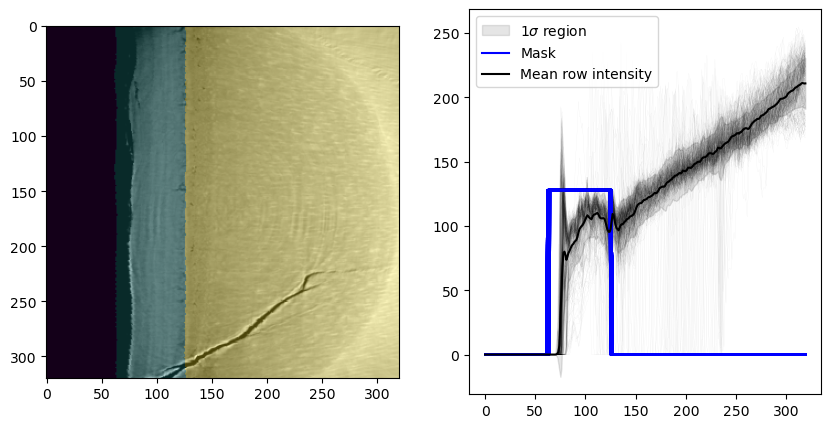

In [1]:
"""
First we'll need the straightened image and mask

"""
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fix, axes = plt.subplots(1, 2, figsize=(10, 5))

image = np.load("straightened_image.npy")
mask = np.load("straightened_mask.npy")

axes[0].imshow(image, cmap="gray")
axes[0].imshow(mask, alpha=0.3)

for im_row, mask_row in zip(image, mask):
    axes[1].plot(im_row, color="k", alpha=0.1, linewidth=0.1)
    axes[1].plot(mask_row * 128, color="b", label="mask")

axes[1].plot(np.mean(image, axis=0), color="k")

axes[1].fill_between(
    np.arange(image.shape[1]),
    np.mean(image, axis=0) - np.std(image, axis=0),
    np.mean(image, axis=0) + np.std(image, axis=0),
    color="k",
    alpha=0.1,
)

axes[1].legend(
    handles=[
        Patch(color="k", alpha=0.1),
        Line2D([], [], color="b"),
        Line2D([], [], color="k"),
    ],
    labels=[rf"1$\sigma$ region", "Mask", "Mean row intensity"],
)

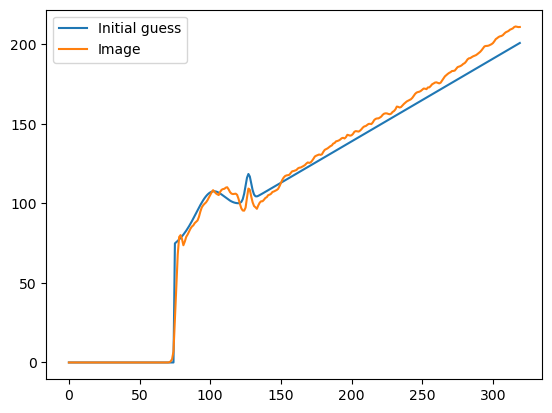

In [2]:
"""
We can try to fit a function to it that gives the positions of the start and end of the cementum region

There will be a constant, a wide Gaussian for the inside of the cementum region, a narrow gaussian for the end of the cementum region 

"""
from scipy.stats import norm


def fit_fcn(x, a, b, h1, d1, s1, h2, d2, s2, k):
    """
    Fit function to find the cementum region

    parameterised such that d1, d2 > 0

    :param x: x value
    :param a: constant, below which f(x) = 0
    :param b: height of step
    :param h1: height of first Gaussian
    :param d1: a + d1 is the mean of the first Gaussian (m1)
    :param s1: width of first Gaussian
    :param h2: height of second Gaussian
    :param d2: m1 + d2 is the mean of the second Gaussian (m2)
    :param s2: width of second Gaussian
    :param k: gradient of linear term

    """
    gauss1 = h1 * norm(loc=a + d1, scale=s1).pdf(x)
    gauss2 = h2 * norm(loc=a + d1 + d2, scale=s2).pdf(x)

    retval = b + gauss1 + gauss2 + k * x

    # Set values below a to 0
    retval[x < a] = 0

    return retval


# Just plot it for now so we can see what it looks like
x = np.arange(image.shape[0])

initial_guess = [75, 35, 500, 25, 10, 85, 27, 2, 0.52]

y = fit_fcn(x, *initial_guess)

plt.plot(x, y, label="Initial guess")
plt.plot(x, np.mean(image, axis=0), label="Image")

plt.legend()

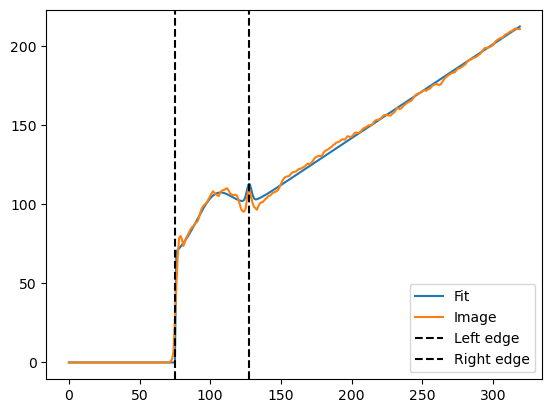

In [3]:
"""
Fit to the mean intensity across the rows

"""
from scipy.optimize import curve_fit

bounds = (
    [0, 0, -np.inf, 0, 0, 0, 0, 0, -np.inf],
    [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf],
)
popt, pcov = curve_fit(
    fit_fcn,
    x,
    np.mean(image, axis=0),
    p0=initial_guess,
    absolute_sigma=True,
    bounds=bounds,
)


plt.plot(x, fit_fcn(x, *popt), label="Fit")
plt.plot(x, np.mean(image, axis=0), label="Image")


a, d1, d2 = [popt[i] for i in (0, 3, 6)]
left_edge, right_edge = a, a + d1 + d2

plt.axvline(left_edge, color="k", linestyle="--", label="Left edge")
plt.axvline(right_edge, color="k", linestyle="--", label="Right edge")

plt.legend()

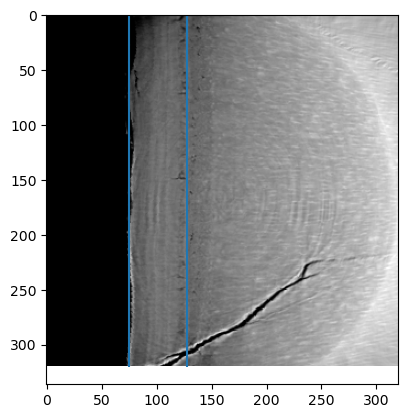

In [4]:
"""
Show the fitted edges on the image

"""

plt.imshow(image, cmap="gray")
plt.vlines(left_edge, 0, image.shape[0])
plt.vlines(right_edge, 0, image.shape[0])

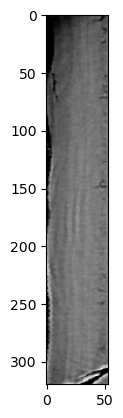

In [5]:
"""
Set the rest of the image to black

"""
cropped_image = image[:, int(left_edge) : int(right_edge) + 1]

plt.imshow(cropped_image, cmap="gray")

Next we want to remove any noise from the columns. We expect the columns to closely follow the layers, so we will remove any peaking noise from them.

We may want to perform contrast normalisation here

Now that we have removed the noise from the columns, we can apply a vertical Gaussian filter that will help to distinguish the edges.

Now that we've increased the contrast between columns, we can perform fits to isolate the increments